# Fitting of NIS tunneling spectroscopy measurments

In [1]:
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyusadel import (
    UsadelProblem,
    fit_nis,
    resize_linspace,
    thermal_broadening,
    trivial_diffops,
)
from tqdm.notebook import tqdm

In [2]:
k_B = 86.17e-6

In [3]:
def add_label(ax, text, position="tl", color=[1, 1, 1, 0.90]):
    if position == "tl":
        ax.text(
            0.03,
            0.96,
            text,
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=8,
            transform=ax.transAxes,
            bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
        )
    elif position == "tr":
        ax.text(
            0.65,
            0.96,
            text,
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=8,
            transform=ax.transAxes,
            bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
        )
    elif position == "bl":
        ax.text(
            0.03,
            0.1,
            text,
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=8,
            transform=ax.transAxes,
            bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
        )
    elif position == "br":
        ax.text(
            0.65,
            0.1,
            text,
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=8,
            transform=ax.transAxes,
            bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
        )
    else:
        pass

In [4]:
def plot_cut(v_ax, g_exp, Delta, h, tau_sf_inv, tau_so_inv, x_N, T, Gamma, G_N):

    up = UsadelProblem(
        Nsites=1,
        diff_ops=trivial_diffops(),
        h_x=np.array([0.0]) + h,
        h_y=np.array([0.0]),
        h_z=np.array([0.0]),
        tau_sf_inv=np.array([0.0]) + tau_sf_inv,
        tau_so_inv=np.array([0.0]) + tau_so_inv,
        D=0,
        T=T,
        Gamma=Gamma,
    )

    up.Delta = np.array([Delta])

    up.set_real_omega_ax(-2.05, 2.05, 701)
    up.solve_spectral()

    DOS_fit = thermal_broadening(
        up.get_omega_ax_r(), G_N * ((1 - x_N) * up.get_ldos()[:, 0] + x_N), T
    )
    DOS_fitu = thermal_broadening(
        up.get_omega_ax_r(), G_N * up.get_spin_resolved_ldos("x")[0][:, 0], T
    )
    DOS_fitd = thermal_broadening(
        up.get_omega_ax_r(), G_N * up.get_spin_resolved_ldos("x")[1][:, 0], T
    )

    #############################

    # Plot the fitting together with the experimental data

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hlines([G_N], -2, 2, "k", linestyles="--", linewidths=0.5)
    ax.plot(up.get_omega_ax_r(), DOS_fit, "-", label=r"$G_\mathrm{fit}$")
    ax.plot(
        up.get_omega_ax_r(),
        DOS_fitu,
        "-",
        linewidth=0.5,
        label=r"$G_{\mathrm{fit} \uparrow}$",
    )
    ax.plot(
        up.get_omega_ax_r(),
        DOS_fitd,
        "--",
        linewidth=0.5,
        label=r"$G_{\mathrm{fit} \downarrow}$",
    )
    ax.plot(
        v_ax,
        g_exp,
        ".",
        markersize=4,
        label=r"$G_\mathrm{exp}$",
    )

    ax.set_xlabel(r"$V$ (meV)")
    ax.set_ylabel(r"$G$ ($e^2/\hbar$)")

    fig.tight_layout()

In [5]:
map_file_url = "../exp_data/NIS_data/MDC004.Sample1/15.dat"

In [6]:
match = re.search(r"\.(\w+)", map_file_url)
sample_name = match.group(1)

match = re.search(r"/(\d+)\.dat$", map_file_url)
RunID = match.group(1)

fit_result_url = (
    f"./fitting_results/MDC004_{sample_name}_RunID_{RunID}_lockin6_M_fit"
)

# Load data

In [7]:
# Import the dataset
data = pd.read_table(map_file_url)
data

,magnet_bpar,v_bias,lockin_6_CondX
0,-0.2,-0.00100,0.166720
1,-0.2,-0.00099,0.166689
2,-0.2,-0.00098,0.166350
3,-0.2,-0.00097,0.166135
4,-0.2,-0.00096,0.166197
...,...,...,...
40396,0.2,0.00096,0.165120
40397,0.2,0.00097,0.165089
40398,0.2,0.00098,0.165735
40399,0.2,0.00099,0.166320


In [8]:
# Extract the data from the dataset
b_N = data["magnet_bpar"].value_counts()[0]
v_N = data["v_bias"].value_counts()[0]

b = data["magnet_bpar"].to_numpy().reshape((b_N, v_N)) * 1e3
_v = data["v_bias"].to_numpy().reshape((b_N, v_N)) * 1e3

g = data["lockin_6_CondX"].to_numpy().reshape((b_N, v_N))

b_ax = b[:, 0]
_v_ax = _v[0, :]

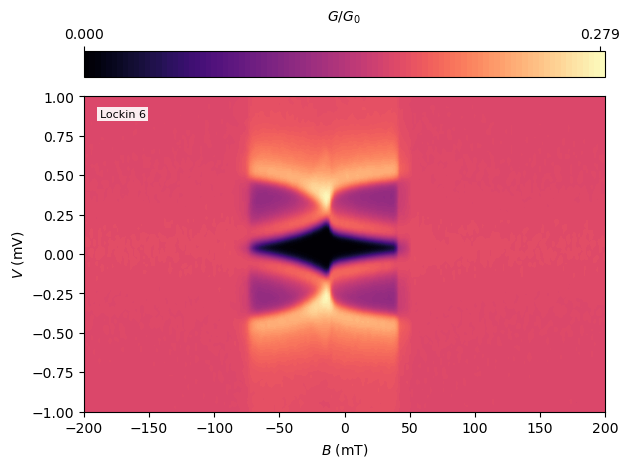

In [9]:
# Plot the data
fig, (ax1) = plt.subplots()
im1 = ax1.contourf(b, _v, g, levels=100, cmap="magma")
add_label(ax1, "Lockin 6")
cbar1 = plt.colorbar(im1, ax=ax1, location="top")
cbar1.set_ticks([0, g.max()])

ax1.set_ylabel(r"$V$ (mV)")
ax1.set_xlabel(r"$B$ (mT)")
cbar1.set_label(r"$G/G_0$ ")

fig.tight_layout()

# Compensation of the voltage offset

In [11]:
# RunID_15, RunID_16
v_offset = +0.042

# RunID_24, RunID_25
# v_offset = +0.032

# RunID_39, RunID_40
# v_offset = -0.054

# RunID_96, RunID_97
# v_offset = +0.038

In [12]:
v_ax = _v_ax - v_offset
v = _v - v_offset

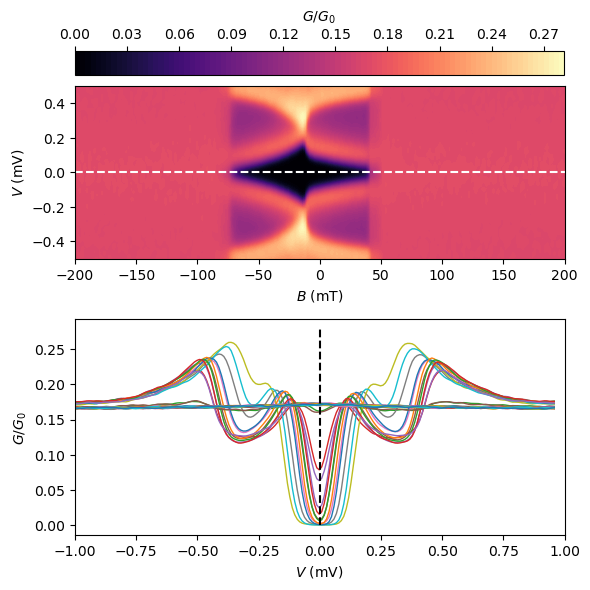

In [13]:
# Plot the data
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 6))
im1 = ax1.contourf(b, v, g, levels=100, cmap="magma")
cbar1 = plt.colorbar(im1, ax=ax1, location="top")
cbar1.set_label(r"$G/G_0$ ")

ax1.hlines([0], -200, 200, "w", linestyles="--")
ax1.set_ylim(-0.5, 0.5)

ax2.plot(v_ax, g[0:b_N:5].T, linewidth=1)
ax2.vlines([0], -0, g.max(), "k", linestyles="--")

ax2.set_xlim(-1, 1)
# ax2.set_ylim(-0.02, 100)

ax1.set_ylabel(r"$V$ (mV)")
ax1.set_xlabel(r"$B$ (mT)")
cbar1.set_label(r"$G/G_0$ ")

ax2.set_ylabel(r"$G/G_0$ ")
ax2.set_xlabel(r"$V$ (mV)")


fig.tight_layout()

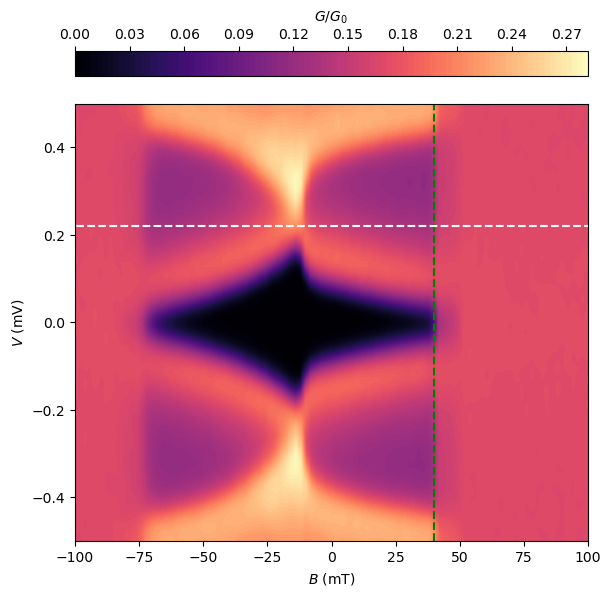

In [14]:
# Plot the data
fig, (ax1) = plt.subplots(nrows=1, figsize=(6, 6))
im1 = ax1.contourf(b, v, g, levels=100, cmap="magma")
cbar1 = plt.colorbar(im1, ax=ax1, location="top")

ax1.set_ylim(-0.5, 0.5)

ax1.set_xlim(-100, 100)
# ax2.set_ylim(-0.02, 100)
ax1.vlines([+40], -0.5, 0.5, "g", linestyles="--")
ax1.hlines([0.220], -200, 200, "w", linestyles="--")

fig.tight_layout()

ax1.set_ylabel(r"$V$ (mV)")
ax1.set_xlabel(r"$B$ (mT)")
cbar1.set_label(r"$G/G_0$ ")

# Fitting of G_N

In [15]:
# RunID 15, 16
v_min, v_max = 0.50, 1.00
b_min, b_max = 100, 250

# RunID 24, 25
# v_min, v_max = 0.50, 1.0
# b_min, b_max = 150, 250

# RunID 39
# b_min, b_max = 50, 100

# RunID  40
# b_min, b_max = -100, -50

# RunID 96
# v_min, v_max = 0.40, 2
# b_min, b_max = 170, 250

# RunID 97
# b_min, b_max = -200, -170

In [16]:
v_min_idx, v_max_idx = np.argmin(np.abs(v_ax - v_min)), np.argmin(np.abs(v_ax - v_max))
b_min_idx, b_max_idx = np.argmin(np.abs(b_ax - b_min)), np.argmin(np.abs(b_ax - b_max))

v_min, v_max = v_ax[[v_min_idx, v_max_idx]]
b_min, b_max = b_ax[[b_min_idx, b_max_idx]]

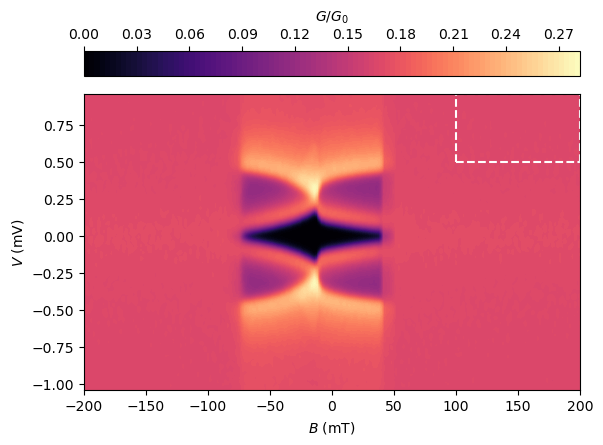

In [17]:
# Plot the data
fig, ax1 = plt.subplots(ncols=1, sharey=True)
im1 = ax1.contourf(b, v, g, levels=100, cmap="magma")
cbar1 = plt.colorbar(im1, ax=ax1, location="top")

ax1.hlines([v_min, v_max], b_min, b_max, "w", linestyles="--")
ax1.vlines([b_min, b_max], v_min, v_max, "w", linestyles="--")

ax1.set_ylabel(r"$V$ (mV)")
ax1.set_xlabel(r"$B$ (mT)")
cbar1.set_label(r"$G/G_0$ ")

In [18]:
G_N = np.mean(g[b_min_idx:b_max_idx, v_min_idx:v_max_idx])
Sigma_GN = np.var(g[b_min_idx:b_max_idx, v_min_idx:v_max_idx])

print(f"G_N = {G_N:3.2f}")
print(f"Sigma_GN = {Sigma_GN:3.2f}")

G_N = 0.17
Sigma_GN = 0.00


In [19]:
# Dynes parameter

Gamma = 1e-6
Sigma_Gamma = 0.0

print(f"Gamma = {Gamma:3.2e}")
print(f"Sigma_Gamma = {Sigma_Gamma:3.2e}")

Gamma = 1.00e-06
Sigma_Gamma = 0.00e+00


# Extraction of x_N

In [20]:
v_zb = np.argmin(abs(v_ax))
g_zb = g[:, v_zb]

In [21]:
x_N = g_zb / G_N
# x_N = x_N.clip(0, 1)

In [22]:
x_N.max()

1.0434609818595184

Text(0.5, 0, '$B$ (mT)')

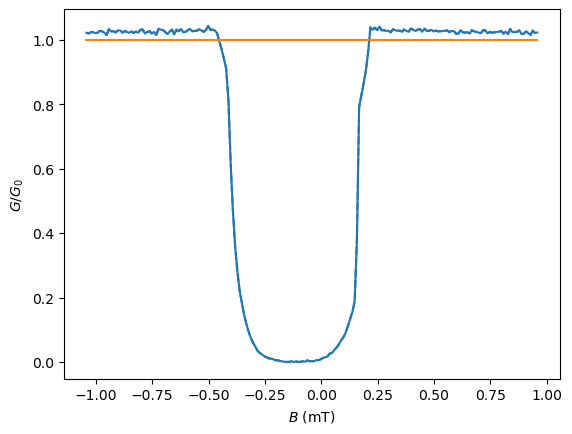

In [23]:
fig, ax = plt.subplots()

ax.plot(v_ax, x_N)
ax.plot(v_ax, g_zb / G_N, "--C0")
ax.plot(v_ax, v_ax * 0 + 1)

ax.set_ylabel(r"$G/G_0$ ")
ax.set_xlabel(r"$B$ (mT)")

# Set the temperature

In [24]:
T = 40 * k_B

# Prefitting

In [25]:
# RunID_15
b_min, b_max, b_start = -80, 50, -12

# RunID_16
# b_min, b_max, b_start = -50, 80, 12

# RunID_24
# b_min, b_max, b_start = -100, 75, -12

# RunID 39
# b_min, b_max, b_start = -80, 44, -12

# RunID 40
# b_min, b_max, b_start = -42, 80, +12

# RunID 96 g_1, g_2
# b_min, b_max, b_start = -190, 160, -15

# RunID 97 g1, g2
# b_min, b_max, b_start = -160, 190, +15


b_min_idx, b_max_idx, b_start_idx = (
    np.argmin(np.abs(b_ax - b_min)),
    np.argmin(np.abs(b_ax - b_max)),
    np.argmin(np.abs(b_ax - b_start)),
)

prefitting_idx = b_start_idx + 10

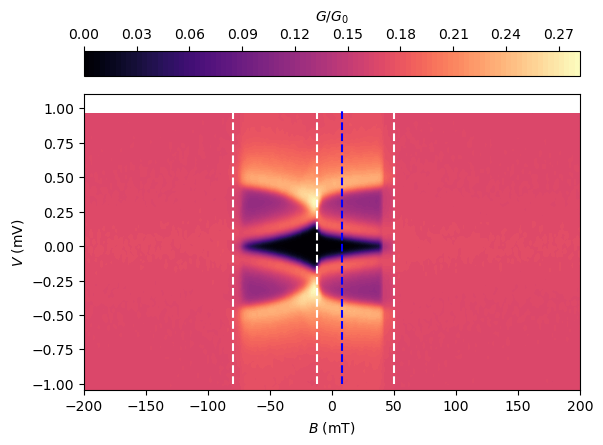

In [26]:
# Plot the data
fig, ax1 = plt.subplots(ncols=1, sharey=True)
im1 = ax1.contourf(b, v, g, levels=100, cmap="magma")
cbar1 = plt.colorbar(im1, ax=ax1, location="top")

ax1.vlines([b_min, b_start, b_max], -1, 1, "w", linestyles="--")
ax1.vlines([b_ax[prefitting_idx]], -1, 1, "b", linestyles="--")

ax1.set_ylabel(r"$V$ (mV)")
ax1.set_xlabel(r"$B$ (mT)")
cbar1.set_label(r"$G/G_0$ ")

In [27]:
params = dict(
    Delta=(0, 0.260, 0.400),
    h=(0.0, 0.040, 0.350),
    G_N=G_N,
    T=T,
    tau_sf_inv=(0.0, 0.04, 0.3),
    tau_so_inv=(0.0, 0.03, 0.1),
    Gamma=Gamma,
    x_N=x_N[prefitting_idx],
)

popt, pcov = fit_nis(
    e_ax_exp=v_ax,
    dos_exp=g[prefitting_idx],
    **params,
    verbose=True,
    tol=1e-8,
)

Delta = 0.2600, h = 0.0400, tau_sf_inv = 0.0400, tau_so_inv = 0.0300, 
Delta = 0.2600, h = 0.0400, tau_sf_inv = 0.0400, tau_so_inv = 0.0300, 
Delta = 0.2600, h = 0.0400, tau_sf_inv = 0.0400, tau_so_inv = 0.0300, 
Delta = 0.2600, h = 0.0400, tau_sf_inv = 0.0400, tau_so_inv = 0.0300, 
Delta = 0.2600, h = 0.0400, tau_sf_inv = 0.0400, tau_so_inv = 0.0300, 
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.0486e-01                                    1.95e+00    
Delta = 0.2813, h = 0.0550, tau_sf_inv = 0.0627, tau_so_inv = 0.0302, 
Delta = 0.2813, h = 0.0550, tau_sf_inv = 0.0627, tau_so_inv = 0.0302, 
Delta = 0.2813, h = 0.0550, tau_sf_inv = 0.0627, tau_so_inv = 0.0302, 
Delta = 0.2813, h = 0.0550, tau_sf_inv = 0.0627, tau_so_inv = 0.0302, 
Delta = 0.2813, h = 0.0550, tau_sf_inv = 0.0627, tau_so_inv = 0.0302, 
       1              2         3.2412e-01      8.07e-02       3.46e-02       1.72e+00    
Delta = 0.2966, h

In [28]:
Delta, h, tau_sf_inv, tau_so_inv = popt

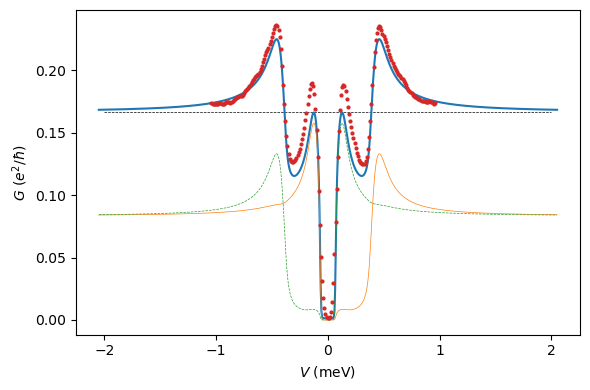

In [29]:
plot_cut(
    v_ax=v_ax,
    g_exp=g[prefitting_idx],
    Delta=Delta,
    h=h,
    tau_sf_inv=tau_sf_inv,
    tau_so_inv=tau_so_inv,
    x_N=x_N[prefitting_idx],
    T=T,
    Gamma=Gamma,
    G_N=G_N,
)

# Fitting of the other parameters

In [30]:
popt = np.zeros((b_N, 2))
pcov = np.zeros((b_N, 2, 2))
fits = np.zeros((b_N, v_N))

In [31]:
new_length = v_ax.shape[0] * 1.2
e_ax_model = resize_linspace(v_ax, new_length)

theta = np.ones((e_ax_model.shape[0], 1), dtype=complex)
M_x = np.zeros((e_ax_model.shape[0], 1), dtype=complex)

params = dict(
    Delta=[0, 0.260, 0.400],
    h=[0.0, 0.040, 0.350],
    G_N=G_N,
    T=T,
    tau_sf_inv=tau_sf_inv,
    tau_so_inv=tau_so_inv,
    Gamma=Gamma,
    x_N=x_N[prefitting_idx],
)

In [32]:
idxs = list(range(b_start_idx, b_max_idx)) + list(range(b_start_idx - 1, b_min_idx, -1))

In [33]:
for i in tqdm(idxs):

    params["x_N"] = x_N[i]

    _popt, _pcov = fit_nis(
        e_ax_exp=v_ax,
        dos_exp=g[i],
        **params,
        verbose=True,
        tol=1e-8,
        solution=(theta, M_x),
    )
    popt[i] = _popt
    pcov[i] = _pcov
    initial_guess = _popt

    Delta, h = _popt

    params["Delta"][1] = Delta
    params["h"][1] = h

    print(f"""B={b_ax[i]:3.1f}: Delta = {Delta:4.3f}, h = {h:4.3f}""")

  0%|          | 0/64 [00:00<?, ?it/s]

Delta = 0.2600, h = 0.0400, 
Delta = 0.2600, h = 0.0400, 
Delta = 0.2600, h = 0.0400, 
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.5413e-02                                    1.44e-01    
Delta = 0.2667, h = 0.0345, 
Delta = 0.2667, h = 0.0345, 
Delta = 0.2667, h = 0.0345, 
       1              2         3.6993e-02      8.42e-03       8.62e-03       6.10e-02    
Delta = 0.2696, h = 0.0291, 
Delta = 0.2696, h = 0.0291, 
Delta = 0.2696, h = 0.0291, 
       2              3         3.5384e-02      1.61e-03       6.16e-03       1.34e-02    
Delta = 0.2701, h = 0.0283, 
Delta = 0.2700, h = 0.0290, 
Delta = 0.2700, h = 0.0290, 
Delta = 0.2700, h = 0.0290, 
       3              5         3.5358e-02      2.65e-05       4.01e-04       1.07e-03    
Delta = 0.2699, h = 0.0288, 
Delta = 0.2699, h = 0.0288, 
Delta = 0.2699, h = 0.0288, 
       4              6         3.5354e-02      3.87e-06       2.26e-04       6.0

In [34]:
keys = ("Delta", "h")

popt_df = pd.DataFrame(popt, columns=keys, index=b_ax)
popt_df.index.name = "B"

popt_df["Sigma_D_D"] = pcov[:, 0, 0]
popt_df["Sigma_D_h"] = pcov[:, 0, 1]
popt_df["Sigma_h_h"] = pcov[:, 1, 1]

popt_df["tau_sf_inv"] = tau_sf_inv
popt_df["tau_so_inv"] = tau_so_inv
popt_df["x_N"] = x_N
popt_df["G_N"] = G_N
popt_df["Sigma_GN"] = Sigma_GN

popt_df["Gamma"] = Gamma
popt_df["Sigma_Gamma"] = Sigma_Gamma

popt_df["T"] = T

# popt_df.to_csv(fit_result_url + ".csv")

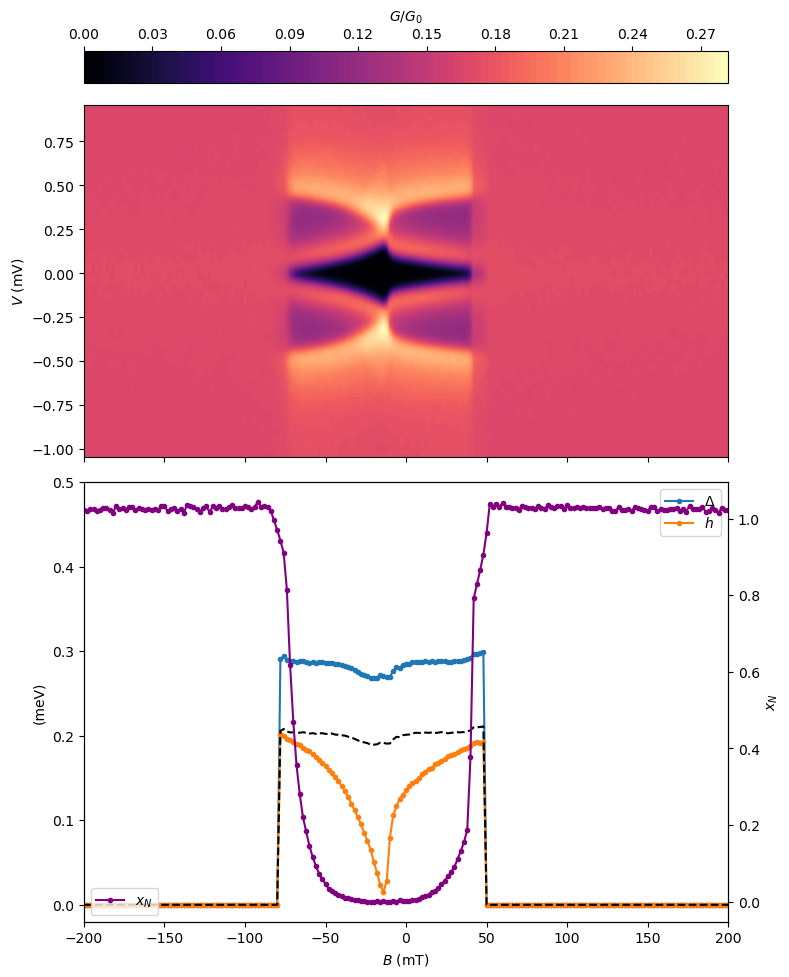

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8, 10))

im1 = ax1.contourf(b, v, g, levels=100, cmap="magma")
cbar1 = plt.colorbar(im1, ax=ax1, location="top")
ax1.set_ylabel(r"$V$ (mV)")
cbar1.set_label(r"$G/G_0$ ")

ax2.plot(b_ax, popt[:, 0], ".-", label=r"$\Delta$")
ax2.plot(b_ax, popt[:, 1], ".-", label=r"$h$")
ax2.plot(b_ax, popt[:, 0] / np.sqrt(2), "--k")

ax2.set_xlabel(r"$B$ (mT)")
ax2.set_ylim(-0.02, 0.5)
ax2.set_ylabel("(meV)")
ax2.legend()

ax2b = ax2.twinx()
ax2b.plot(b_ax, x_N, ".-", color="purple", label=r"$x_N$")
ax2b.legend()
ax2b.set_ylabel(r"$x_N$")

fig.tight_layout()